# Fraud Detection with XGBoost and Machine Learning in Watson Studio Local
<a id='toc'></a>

The data is simulated for demo purpose only.

1. [Imports](#Imports)
2. [UDFs](#udf)
3. [Load Data](#LoadData)
4. [Exploratory Data Analysis](#eda)
5. [Split into Training and Test](#split)
6. [XGboost](#xgboost)  
    6.1 [Using Default Setting from Modeler](#bsl)  
    6.2 [Plot Feature Importance](#imp)    
7. [Build Pipeline](#ppl)
8. [Save Model](#save)
9. [Use scale_pos_weight to take care of imbalance](#test)
10. [Notes and Further Reads](#note)

<a id='Imports'></a>
## Imports
<div style="text-align: right"> [Top](#toc) </div>

In [12]:
import xgboost as xgb
print(xgb.__version__)

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn_pandas import DataFrameMapper

#import brunel
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

0.90


In [2]:
#!pip install xgboost

     |████████████████████████████████| 686kB 590kB/s eta 0:00:01
  Created wheel for xgboost: filename=xgboost-0.90-cp37-cp37m-macosx_10_9_x86_64.whl size=1696834 sha256=092c78879510b070b72536a7398539e5a5c128c48ea6a33cfcd41c4dccd8a112
  Stored in directory: /Users/catherinecao/Library/Caches/pip/wheels/e9/48/4d/de4187b5270dff71d3697c5a7857a1e2d9a0c63a28b3462eeb
Successfully built xgboost


In [5]:
#!pip install sklearn_pandas

In [3]:
!ls

Current_Transactions_v7.csv
Fraud Spark Model
History_Transactions_v4.csv
WSL 1.2.3 - Basics of Skytap Provisioning.docx
XGBoost_v6.jupyter-py35.ipynb
XGboost_v3.jupyter.ipynb
mmd.lic


In [8]:
#!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /opt/conda2/lib/python2.7/site-packages (0.20.4)
You are using pip version 18.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


<a id='udf'></a>
## UDFs
<div style="text-align: right"> [Top](#toc) </div>

In [ ]:
[ expression for item in list if conditional ]

In [71]:
[x+1 if x >= 45 else x+5 for x in l] 

NameError: name 'l' is not defined

In [72]:
from sklearn import metrics
def evaluate_it(alg, k):
    pred = alg.predict_proba(X_test_maptrsfm)[:,1]
    auc = roc_auc_score(y_test,pred)
    pred = [ 1 if x >= k else 0 for x in pred]
    print("*****Confusion Matrix *****")
    print(confusion_matrix(y_test, pred))
    print("*****Classification Report*****")
    print(classification_report(y_test, pred))
    print("AUC: " +  str(auc))

<a id='LoadData'></a>
## Load Data
<div style="text-align: right"> [Top](#toc) </div>

In [2]:
import os, pandas as pd
# Add asset from file system
#df_data_1 = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/History_Transactions_v4.csv')
df_data_1 = pd.read_csv("History_Transactions_v4.csv")
# only keep variables we will use later
df_data_1 = df_data_1[['Dollar_Amount', 
                       'Transaction_Type',
                       'Store_Type', 
                       'Cardholder_Region', 
                       'Country',
                       'Fraudulent',
                       'Last3hourTransactions',
                       'Hours_Since_Last_Transaction'
                      ]]
df_data_1.head()

,Dollar_Amount,Transaction_Type,Store_Type,Cardholder_Region,Country,Fraudulent,Last3hourTransactions,Hours_Since_Last_Transaction
0,188.56,swiped,ATM Withdrawal,E,USA,F,4,21
1,160.54,keyed,Grocery,NE,Australia,F,3,21
2,153.24,swiped,Retail - Pharmacy,SW,European Union,T,2,21
3,148.66,keyed,Communications - telephone and wireless,NW,USA,F,1,35
4,174.03,keyed,Spa/Beauty,SW,Asia,F,1,25


<a id='eda'></a>
## Exploratory Data Analysis
<div style="text-align: right"> [Top](#toc) </div>

The data is actually well cleaned so we will just focus on the SMOTE and XGB, and keep data prep and EDA to minimal.

In [10]:
# check missing
df_data_1.apply(lambda x: sum(x.isnull()))

Dollar_Amount                   0
Transaction_Type                0
Store_Type                      0
Cardholder_Region               0
Country                         0
Fraudulent                      0
Last3hourTransactions           0
Hours_Since_Last_Transaction    0
dtype: int64

In [11]:
# Look at categorical variables
var = ['Fraudulent', 'Transaction_Type', 'Store_Type', 'Cardholder_Region', 'Country']
for v in var:
    print("****************************************")
    print('\nFrequency count for variable %s'%v)
    print(df_data_1[v].value_counts())

****************************************

Frequency count for variable Fraudulent
F    52132
T     2903
Name: Fraudulent, dtype: int64
****************************************

Frequency count for variable Transaction_Type
swiped    27623
keyed     27412
Name: Transaction_Type, dtype: int64
****************************************

Frequency count for variable Store_Type
Restaurant                                 4470
Professional Services                      3443
Grocery                                    3403
Gas                                        3261
Other                                      3226
Hotel                                      3206
Retail - Apparel                           2276
ATM Withdrawal                             2240
Retail - Furniture                         2232
Entertainment and Arts                     2207
Retail - Home Improvement                  2194
Retail - Drug Store                        2193
Communications - telephone and wireless    2191
Me

<a id='split'></a>

## Split into Training and Test
<div style="text-align: right"> [Top](#toc) </div>

In [3]:
y = df_data_1['Fraudulent'].map(lambda l: 1 if l == 'T' else 0)
X = df_data_1.drop(['Fraudulent'], axis=1)

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234567)

print("Number of training records: " + str(len(X_train)))
print("Training: T = : " + str(sum(y_train)))
print("Training: F = : " + str(len(X_train) - sum(y_train)))
print("Number of testing records : " + str(len(X_test)))
print("Testing: T = : " + str(sum(y_test)))
print("Testing: F = : " + str(len(X_test) - sum(y_test)))

Number of training records: 44028
Training: T = : 2304
Training: F = : 41724
Number of testing records : 11007
Testing: T = : 599
Testing: F = : 10408


The data is imbalanced. Use SMOTE to rebalance the dataset. Make sure you use Python 3.x.

In [14]:
#!pip install imblearn

     |████████████████████████████████| 163kB 498kB/s eta 0:00:01
     |████████████████████████████████| 10.9MB 4.9MB/s eta 0:00:01
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


In [8]:
# restart kernel if see error
from imblearn.over_sampling import SMOTENC

In [10]:
X_train_dummy = pd.get_dummies(X_train)
#sm = SMOTE(random_state=2662761, sampling_strategy = 'auto', k_neighbors = 5)
sm = SMOTENC(random_state=42, categorical_features=list(range(3, 44)))
X_train_res, y_train_res = sm.fit_sample(X_train_dummy, y_train)


print('Fraud/Non-Fraud Ratio Before SMOTE: ' + str(y_train.sum()/len(y_train)))
print('Fraud/Non-Fraud Ratio After SMOTE: ' + str(y_train_res.sum()/len(y_train_res)))

print("Fraud in Training after SMOTE = T: " + str(sum(y_train_res)))
print("Fraud in Training after SMOTE = F: " + str(len(y_train_res) - sum(y_train_res)))
print("\n************Test Set************\n")
print("Number of testing records : " + str(len(X_test)))
print("Training: T = : " + str(sum(y_test)))
print("Training: F = :" + str(len(y_test) - sum(y_test)))

Fraud/Non-Fraud Ratio Before SMOTE: 0.05233033524121014
Fraud/Non-Fraud Ratio After SMOTE: 0.5
Fraud in Training after SMOTE = T: 41724
Fraud in Training after SMOTE = F: 41724

************Test Set************

Number of testing records : 11007
Training: T = : 599
Training: F = :10408


In [17]:
# in order to build pipeline, we need to reverse the matrix returned by SMOTE to df
X_train_df = pd.DataFrame(X_train_res)
X_train_df.columns = pd.get_dummies(X_train).columns.tolist()

X_train_df['Transaction_Type'] = X_train_df[['Transaction_Type_keyed', 'Transaction_Type_swiped']].idxmax(axis=1).map(lambda l: l.replace('Transaction_Type_', ''))
X_train_df['Store_Type'] = X_train_df[['Store_Type_ATM Withdrawal',
       'Store_Type_Communications - telephone and wireless',
       'Store_Type_Education and Instruction',
       'Store_Type_Entertainment and Arts', 'Store_Type_Gas',
       'Store_Type_Grocery', 'Store_Type_Hotel', 'Store_Type_Medical',
       'Store_Type_Other', 'Store_Type_Professional Services',
       'Store_Type_Restaurant', 'Store_Type_Retail - Apparel',
       'Store_Type_Retail - Books', 'Store_Type_Retail - Convenience Store',
       'Store_Type_Retail - Drug Store', 'Store_Type_Retail - Floral',
       'Store_Type_Retail - Furniture', 'Store_Type_Retail - Home Electronics',
       'Store_Type_Retail - Home Improvement',
       'Store_Type_Retail - Jewelry and Watches',
       'Store_Type_Retail - Office and School Supplies',
       'Store_Type_Retail - Pharmacy', 'Store_Type_Retail - Toys',
       'Store_Type_Retail - Weapons', 'Store_Type_Spa/Beauty',
       'Store_Type_Utilities', 'Store_Type_e-Retail']].idxmax(axis=1).map(lambda l: l.replace('Store_Type_', ''))

X_train_df['Country'] = X_train_df[['Country_Asia', 'Country_Australia',
       'Country_European Union', 'Country_USA']].idxmax(axis=1).map(lambda l: l.replace('Country_', ''))

X_train_df['Cardholder_Region'] = X_train_df[['Cardholder_Region_E',
       'Cardholder_Region_N', 'Cardholder_Region_NE', 'Cardholder_Region_NW',
       'Cardholder_Region_S', 'Cardholder_Region_SE', 'Cardholder_Region_SW',
       'Cardholder_Region_W']].idxmax(axis=1).map(lambda l: l.replace('Cardholder_Region_', ''))

X_train_df = X_train_df.drop(['Transaction_Type_keyed', 'Transaction_Type_swiped', 'Store_Type_ATM Withdrawal',
       'Store_Type_Communications - telephone and wireless',
       'Store_Type_Education and Instruction',
       'Store_Type_Entertainment and Arts', 'Store_Type_Gas',
       'Store_Type_Grocery', 'Store_Type_Hotel', 'Store_Type_Medical',
       'Store_Type_Other', 'Store_Type_Professional Services',
       'Store_Type_Restaurant', 'Store_Type_Retail - Apparel',
       'Store_Type_Retail - Books', 'Store_Type_Retail - Convenience Store',
       'Store_Type_Retail - Drug Store', 'Store_Type_Retail - Floral',
       'Store_Type_Retail - Furniture', 'Store_Type_Retail - Home Electronics',
       'Store_Type_Retail - Home Improvement',
       'Store_Type_Retail - Jewelry and Watches',
       'Store_Type_Retail - Office and School Supplies',
       'Store_Type_Retail - Pharmacy', 'Store_Type_Retail - Toys',
       'Store_Type_Retail - Weapons', 'Store_Type_Spa/Beauty',
       'Store_Type_Utilities', 'Store_Type_e-Retail', 'Country_Asia', 'Country_Australia',
       'Country_European Union', 'Country_USA', 'Cardholder_Region_E',
       'Cardholder_Region_N', 'Cardholder_Region_NE', 'Cardholder_Region_NW',
       'Cardholder_Region_S', 'Cardholder_Region_SE', 'Cardholder_Region_SW',
       'Cardholder_Region_W'], 1)

<a id='xgboost'></a>
## XGBoost
<div style="text-align: right"> [Top](#toc) </div>

<a id='bsl'></a>
### Baseline: Default Setting from Modeler
<div style="text-align: right"> [Top](#toc) </div>

Let's start with the default parameters from Modeler.

In [15]:
# Note: when applying DataFrameMapper call out all required variables even no transformation needed
mapper1 = DataFrameMapper(
    [(['Dollar_Amount'], None),
     (['Last3hourTransactions'], None),
     (['Hours_Since_Last_Transaction'], None),
     ('Transaction_Type', LabelBinarizer()), # for binary, only one variable generated
     ('Store_Type', LabelBinarizer()),
     ('Cardholder_Region', LabelBinarizer()),
     ('Country', LabelBinarizer())
     ])

In [18]:
# smote produce two columns for binary variable, to keep consistancy with dataframe mapper transfomer(produce 1 column for binary) in pipeline later, we maptrsfm the training set here
X_train_res_maptrsfm = mapper1.fit_transform(X_train_df)
X_test_maptrsfm = mapper1.fit_transform(X_test)

In [19]:
xgb_model_spss = XGBClassifier(
    tree_method= "auto",
    n_estimators = 10, 
    max_depth = 6,
    min_child_weight = 1.0,
    max_delta_step = 0.0,
    objective = "binary:logistic",
    seed = 6924827,
    subsample = 1.0,
    learning_rate = .3, # fixed
    gamma = 0.0,
    colsample_bytree = 1.0,
    colsample_bylevel = 1.0,
    reg_lambda = 1.0,
    reg_alpha = 0.0,
    scale_pos_weight = 1.0)

In [20]:
xgb_model_spss.fit(X_train_res_maptrsfm, y_train_res, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(X_test_maptrsfm, y_test)])

[0]	validation_0-auc:0.642501
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.649513
[2]	validation_0-auc:0.651444
[3]	validation_0-auc:0.645609
[4]	validation_0-auc:0.651759
[5]	validation_0-auc:0.650415
[6]	validation_0-auc:0.651413
[7]	validation_0-auc:0.656164
[8]	validation_0-auc:0.654638
[9]	validation_0-auc:0.653524


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.0,
              learning_rate=0.3, max_delta_step=0.0, max_depth=6,
              min_child_weight=1.0, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.0, reg_lambda=1.0, scale_pos_weight=1.0, seed=6924827,
              silent=None, subsample=1.0, tree_method='auto', verbosity=1)

In [23]:
evaluate_it(xgb_model_spss, .5)

*****Confusion Matrix *****
[[9935  473]
 [ 530   69]]
*****Classification Report*****
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10408
           1       0.13      0.12      0.12       599

    accuracy                           0.91     11007
   macro avg       0.54      0.53      0.54     11007
weighted avg       0.90      0.91      0.91     11007

AUC: 0.656164466398648


In [76]:
evaluate_it(xgb_model_spss, .2)

*****Confusion Matrix *****
[[8633 1775]
 [ 423  176]]
*****Classification Report*****
              precision    recall  f1-score   support

           0       0.95      0.83      0.89     10408
           1       0.09      0.29      0.14       599

    accuracy                           0.80     11007
   macro avg       0.52      0.56      0.51     11007
weighted avg       0.91      0.80      0.85     11007

AUC: 0.656164466398648


<a id='imp'></a>
### Plot Feature Importance
<div style="text-align: right"> [Top](#toc) </div>

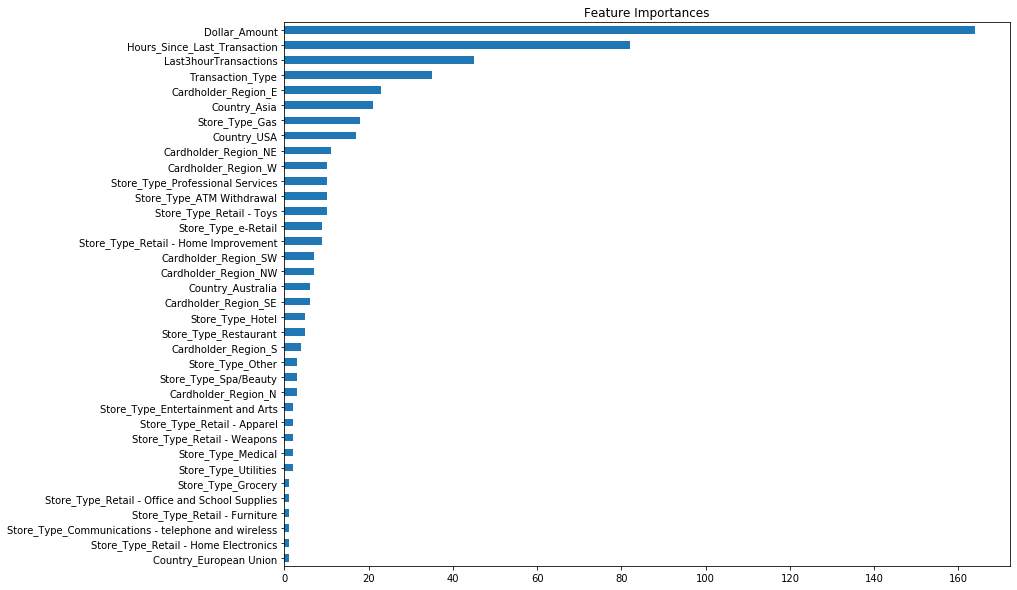

In [24]:
fig, axs = plt.subplots(nrows= 1, figsize=(13, 10))
feat_imp = pd.Series(xgb_model_spss._Booster.get_fscore()).sort_values()
X_train_dummy_names  =  mapper1.fit(X_train_df).transformed_names_

x=[]
for i in range(0, len(X_train_dummy_names)):
    x.append( "f"+ str(i))

feat_imp_reindex = feat_imp.rename(lambda y: dict(zip(x, X_train_dummy_names))[y])
feat_imp_reindex.plot(kind='barh', title='Feature Importances')
fig.show()

<a id='ppl'></a>
## Build Pipeline
<div style="text-align: right"> [Top](#toc) </div>

Now let's build transformers into pipeline and deploy the model.

In [25]:
xgb_model_spss = XGBClassifier(
    tree_method= "auto",
    n_estimators = 10, 
    max_depth = 6,
    min_child_weight = 1.0,
    max_delta_step = 0.0,
    objective = "binary:logistic",
    seed = 6924827,
    subsample = 1.0,
    learning_rate = .3, # fixed
    gamma = 0.0,
    colsample_bytree = 1.0,
    colsample_bylevel = 1.0,
    reg_lambda = 1.0,
    reg_alpha = 0.0,
    scale_pos_weight = 1.0)

In [26]:
# build pipeline
pipeline = Pipeline([('mapper', mapper1), ('classifier', xgb_model_spss)])

In [27]:
xgb_model_spss.fit(X_train_res_maptrsfm, y_train_res, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(X_test_maptrsfm, y_test)])

[0]	validation_0-auc:0.642501
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.649513
[2]	validation_0-auc:0.651444
[3]	validation_0-auc:0.645609
[4]	validation_0-auc:0.651759
[5]	validation_0-auc:0.650415
[6]	validation_0-auc:0.651413
[7]	validation_0-auc:0.656164
[8]	validation_0-auc:0.654638
[9]	validation_0-auc:0.653524


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.0,
              learning_rate=0.3, max_delta_step=0.0, max_depth=6,
              min_child_weight=1.0, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.0, reg_lambda=1.0, scale_pos_weight=1.0, seed=6924827,
              silent=None, subsample=1.0, tree_method='auto', verbosity=1)

In [28]:
# fit ppl
pipeline.fit(X_train_df, y_train_res)

Pipeline(memory=None,
         steps=[('mapper',
                 DataFrameMapper(default=False, df_out=False,
                                 features=[(['Dollar_Amount'], None),
                                           (['Last3hourTransactions'], None),
                                           (['Hours_Since_Last_Transaction'],
                                            None),
                                           ('Transaction_Type',
                                            LabelBinarizer(neg_label=0,
                                                           pos_label=1,
                                                           sparse_output=False)),
                                           ('Store_Type',
                                            LabelBinarizer(neg_label=0,
                                                           pos_label=1,
                                                           sparse_output=False)),
                                      

In [29]:
pred_classifier = pipeline.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test, pred_classifier)
print("*****Confusion Matrix *****")
print(confusion_matrix(y_test, pred_classifier.round()))
print("*****Classification Report*****")
print(classification_report(y_test, pred_classifier.round()))
print("ROC: " +  str(roc))

*****Confusion Matrix *****
[[9935  473]
 [ 530   69]]
*****Classification Report*****
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10408
           1       0.13      0.12      0.12       599

    accuracy                           0.91     11007
   macro avg       0.54      0.53      0.54     11007
weighted avg       0.90      0.91      0.91     11007

ROC: 0.656164466398648


<a id='save'></a>
## Save Model
<div style="text-align: right"> [Top](#toc) </div>

Need to check if DataMapper is supported by current Local WML. Otherwise, use SPARKML to build pipeline.

In [220]:
from dsx_ml.ml import save

In [221]:
model_name = "local_xgb_updated"
save(name = model_name,
     model = pipeline,
     algorithm_type = 'Classification',
     x_test = X_test,
     y_test = pd.DataFrame(y_test))

{'path': '/user-home/1063/DSX_Projects/Fraud Transactions/models/local_xgb_updated/2',
 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python35/scikit-learn-0.22/Fraud%20Transactions/local_xgb_updated/2'}

<a id='test'></a>
## Use scale_pos_weight to take care of imbalance
<div style="text-align: right"> [Top](#toc) </div>

In [32]:
print("Number of training records: " + str(len(X_train)))
print("Training: T = : " + str(sum(y_train)))
print("Training: F = : " + str(len(X_train) - sum(y_train)))
print("Number of testing records : " + str(len(X_test)))
print("Testing: T = : " + str(sum(y_test)))
print("Testing: F = : " + str(len(X_test) - sum(y_test)))

Number of training records: 44028
Training: T = : 2304
Training: F = : 41724
Number of testing records : 11007
Testing: T = : 599
Testing: F = : 10408


In [33]:
X_train_withoutSMOTE = mapper1.fit_transform(X_train)
X_test_withoutSMOTE = mapper1.fit_transform(X_test)

In [39]:
# rule of thumb
spw = round(np.sqrt(41724/2304))

In [83]:
xgb_model = XGBClassifier(
    tree_method= "auto",
    n_estimators = 10, 
    max_depth = 6,
    min_child_weight = 1.0,
    max_delta_step = 0.0,
    objective = "binary:logistic",
    seed = 6924827,
    subsample = 1.0,
    learning_rate = .3, # fixed
    gamma = 0.0,
    colsample_bytree = 1.0,
    colsample_bylevel = 1.0,
    reg_lambda = 1.0,
    reg_alpha = 0.0,
    scale_pos_weight = 4)

In [84]:
xgb_model.fit(X_train_withoutSMOTE, y_train, early_stopping_rounds=20, eval_metric="auc",
        eval_set=[(X_test_withoutSMOTE, y_test)])

[0]	validation_0-auc:0.667062
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.668606
[2]	validation_0-auc:0.67033
[3]	validation_0-auc:0.670184
[4]	validation_0-auc:0.671995
[5]	validation_0-auc:0.67435
[6]	validation_0-auc:0.671631
[7]	validation_0-auc:0.671261
[8]	validation_0-auc:0.672153
[9]	validation_0-auc:0.668923


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.0,
              learning_rate=0.3, max_delta_step=0.0, max_depth=6,
              min_child_weight=1.0, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.0, reg_lambda=1.0, scale_pos_weight=4, seed=6924827,
              silent=None, subsample=1.0, tree_method='auto', verbosity=1)

In [89]:
evaluate_it(xgb_model, .2)

*****Confusion Matrix *****
[[6221 4187]
 [ 200  399]]
*****Classification Report*****
              precision    recall  f1-score   support

           0       0.97      0.60      0.74     10408
           1       0.09      0.67      0.15       599

    accuracy                           0.60     11007
   macro avg       0.53      0.63      0.45     11007
weighted avg       0.92      0.60      0.71     11007

AUC: 0.6743502012706291


In [64]:
xgb_model = XGBClassifier(
    tree_method= "auto",
    n_estimators = 10, 
    max_depth = 6,
    min_child_weight = 1.0,
    max_delta_step = 0.0,
    objective = "binary:logistic",
    seed = 6924827,
    subsample = 1.0,
    learning_rate = .3, # fixed
    gamma = 0.0,
    colsample_bytree = 1.0,
    colsample_bylevel = 1.0,
    reg_lambda = 1.0,
    reg_alpha = 0.0,
    scale_pos_weight = 18)

xgb_model.fit(X_train_withoutSMOTE, y_train, early_stopping_rounds=20, eval_metric="auc",
        eval_set=[(X_test_withoutSMOTE, y_test)])


evaluate_it(xgb_model)


[0]	validation_0-auc:0.65191
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.653981
[2]	validation_0-auc:0.655126
[3]	validation_0-auc:0.659618
[4]	validation_0-auc:0.661355
[5]	validation_0-auc:0.662541
[6]	validation_0-auc:0.667005
[7]	validation_0-auc:0.665705
[8]	validation_0-auc:0.662048
[9]	validation_0-auc:0.661806
*****Confusion Matrix *****
[[7028 3380]
 [ 245  354]]
*****Classification Report*****
              precision    recall  f1-score   support

           0       0.97      0.68      0.79     10408
           1       0.09      0.59      0.16       599

    accuracy                           0.67     11007
   macro avg       0.53      0.63      0.48     11007
weighted avg       0.92      0.67      0.76     11007

AUC: 0.6670048177913741


In [61]:
print("*****SMOTE Results*****")
print("*****Confusion Matrix *****")
print(confusion_matrix(y_test, pred_classifier.round()))
print("*****Classification Report*****")
print(classification_report(y_test, pred_classifier.round()))
print("ROC: " +  str(roc))

*****SMOTE Results*****
*****Confusion Matrix *****
[[9935  473]
 [ 530   69]]
*****Classification Report*****
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10408
           1       0.13      0.12      0.12       599

    accuracy                           0.91     11007
   macro avg       0.54      0.53      0.54     11007
weighted avg       0.90      0.91      0.91     11007

ROC: 0.656164466398648


<a id='test'></a>
## Note:

1. In this case, SMOTE helped get a better recall for the positive class(Fraud). A good recall is prefered for fraud detection if you want to be conservative and capture all potential fraud.

2. Increasing scale_pos_weight trades off precision for the minor class and recall for the major class.

2. SMOTE creates synthetic observations instead of reusing existing observations, so classifier is less likely to overfit, but have to check if those new observations are realistic.

3. [Disadvantages of SMOTE](https://www.datacamp.com/community/tutorials/diving-deep-imbalanced-data): While generating synthetic examples, SMOTE does not take into consideration neighboring examples can be from other classes. This can increase the overlapping of classes and can introduce additional noise.
SMOTE is not very practical for **high dimensional data**.

## Reads:
    * Performance evaluation of class balancing techniques for credit card fraud detection: https://ieeexplore.ieee.org/document/8392219
    
    * Deep dive into imbalanced data: https://www.datacamp.com/community/tutorials/diving-deep-imbalanced-data
    
    * Another IBM notebook on Kaggle Credit Card Default dataset: https://github.com/IBM/xgboost-smote-detect-fraud/blob/master/notebook/Fraud_Detection.ipynb
    
    * A review on  Class Imbalance Problem: http://www.softcomputing.net/jnic2.pdf